# Imports

In [9]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import time, datetime, itertools, pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC 
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from scipy.optimize import curve_fit
from itertools import permutations

# Helpers

In [91]:
def unpickle(file):
  with open(file, 'rb') as fo:
      dict = pickle.load(fo, encoding='bytes')
  return dict

def get_cifar10_data():
  # get train-val data
  for batch in range(1, 6):
    data_dict = unpickle(f"data_batch_{batch}")
    if batch == 1:
      X_train_val = data_dict[b'data']
      y_train_val = data_dict[b'labels']
    else:
      X_train_val = np.concatenate((X_train_val, data_dict[b'data']))
      y_train_val = np.concatenate((y_train_val, data_dict[b'labels']))

  # get test data
  data_dict = unpickle("test_batch")
  X_test = data_dict[b'data']
  y_test = np.array(data_dict[b'labels'])

  # get label names
  data_dict = unpickle("batches.meta")
  label_names = list(str(name)[2:-1] for name in data_dict[b'label_names'])

  return X_train_val, X_test, y_train_val, y_test, label_names


def find_n_components(X_train_val, information_percentage):
  
  pca = PCA()
  pca.fit(X_train_val)
  variance_ratios = pca.explained_variance_ratio_
  sum = variance_ratios[0]
  n_components = 1
  while sum < information_percentage:
    n_components += 1
    sum += variance_ratios[n_components-1] 
  
  return n_components

In [92]:
def preprocess_cifar10_data(X_train_val, y_train_val,
                            X_test, y_test, pca_components, 
                            train_val_split_percentage):

  # PCA train and test sets
  pca = PCA(n_components=pca_components)
  X_train_val_pca = pca.fit_transform(X_train_val)
  X_test_pca = pca.transform(X_test)

  # scale train and test sets
  scaler = MinMaxScaler()
  X_train_val_pca_scaled = scaler.fit_transform(X_train_val_pca)
  X_test_pca_scaled = scaler.transform(X_test_pca)

  # split train-val to train and validation sets
  X_train_pca_scaled, X_val_pca_scaled, y_train, y_val = train_test_split(X_train_val_pca_scaled, y_train_val,
                                                                          test_size=train_val_split_percentage, 
                                                                          shuffle=True)
  
  print(X_train_pca_scaled.shape, X_val_pca_scaled.shape, X_test_pca_scaled.shape, y_train.shape, y_val.shape, y_test.shape)

  return X_train_pca_scaled, X_val_pca_scaled, X_test_pca_scaled, y_train, y_val, y_test


def show_image(X_test, y_test, y_test_preds, label_names, true_class, predicted_class):
  wrong_poss = np.where((y_test == true_class) & (y_test_preds == predicted_class))[0]
  random_sample = np.random.randint(low=0, high=len(wrong_poss)-1, size=1)
  wrong_pos = wrong_poss[random_sample]

  flattened_img = X_test[wrong_pos, :].flatten()
  R = flattened_img[0:1024].reshape(32,32)/255.0
  G = flattened_img[1024:2048].reshape(32,32)/255.0
  B = flattened_img[2048:].reshape(32,32)/255.0  
  random_img = np.dstack((R,G,B))

  plt.imshow(random_img, interpolation='bicubic')
  plt.title(f"True class: {label_names[true_class]}\n Predicted class: {label_names[predicted_class]}")
  plt.show()

In [93]:
def save_results_to_dict(C, gamma, kernel, time_str, train_accuracy, validation_accuracy):
  
  results_dict = {
      "dataset": "Cifar-10",
      "model": "SVM",
      "kernel": kernel,
      "C": C,
      "gamma": gamma,
      "N_train": 30000,
      "N_validation": 20000,
      "N_test": 10000,
      "D": 100,
      "PCA_applied": "YES",
      "k-fold Cross-Validation applied": "NO",
      "Time elapsed": time_str,
      "Train accuracy (%)": train_accuracy,
      "Validation accuracy (%)": validation_accuracy,
  }

  return results_dict

# MAIN

In [13]:
# Get and preprocess data
INFORMATION_PERCENTAGE = 0.9
TRAIN_VAL_SPLIT_PERCENTAGE = 0.4

X_train_val, X_test, y_train_val, y_test, label_names = get_cifar10_data()
n_components = find_n_components(X_train_val, INFORMATION_PERCENTAGE)

print(f"The first {n_components} components of the PCA outcome contain at least", 
      100*INFORMATION_PERCENTAGE, "% of the information of the initial data.")

The first 99 components of the PCA outcome contain at least 90.0 % of the information of the initial data.


In [17]:
# Preprocess data
X_train_pca_scaled, X_val_pca_scaled, X_test_pca_scaled,\
y_train, y_val, y_test = preprocess_cifar10_data(X_train_val, y_train_val, 
                                                 X_test, y_test, n_components, 
                                                 TRAIN_VAL_SPLIT_PERCENTAGE)

(30000, 99) (20000, 99) (10000, 99) (30000,) (20000,) (10000,)


In [4]:
kernel = 'rbf'
C_list = [10]
gamma_list = [1]
results = []
for i, C in enumerate(C_list):
  for j, gamma in enumerate(gamma_list):
    print(f"**************** C = {C}, gamma = {gamma} ****************")

    # start time
    tic = time.time()

    # create and fit our SVM model
    svm = SVC(C=C, gamma=gamma, kernel=kernel, decision_function_shape='ovo')
    svm.fit(X_train_pca_scaled, y_train)

    # Get predictions and check accuracy on the Training set
    y_train_preds = svm.predict(X_train_pca_scaled)
    train_accuracy = float("{:.2f}".format(100 * np.mean(y_train_preds == y_train)))
    print(f"train_accuracy = {train_accuracy} %")

    # Get predictions and check accuracy on the Validation set
    y_val_preds = svm.predict(X_val_pca_scaled)
    val_accuracy = float("{:.2f}".format(100 * np.mean(y_val_preds == y_val)))
    print(f"val_accuracy = {val_accuracy} %")
    
    # end time
    toc = time.time()

    # turn total time from seconds to -> hours, minutes and seconds
    Dt = toc - tic
    total_time = str(datetime.timedelta(seconds=Dt))
    time_split = total_time.split(':')
    hours = int(time_split[0])
    minutes = int(time_split[1])
    seconds = round(float(time_split[2]))
    time_str = str(hours) + 'h  ' + str(minutes) + 'min  ' + str(seconds) + 'sec'

    results_dict = save_results_to_dict(C, gamma, kernel, time_str, train_accuracy, val_accuracy)
    results.append(results_dict)
    print(f"Time elapsed = {hours}h {minutes}min {seconds}sec \n")

**************** C = 10, gamma = 1 ****************
train_accuracy = 97.47 %
val_accuracy = 53.76 %
Time elapsed = 0h 6min 52sec 



In [5]:
# Get predictions on the Test set
y_test_preds = svm.predict(X_test_pca_scaled)
test_accuracy = float("{:.2f}".format(100 * np.mean(y_test_preds == y_test)))
print(f"test_accuracy = {test_accuracy} %")

# create confusion matrix
confusionMatrix = confusion_matrix(y_test, y_test_preds)

# plot confusion matrix
plt.figure(figsize=(30, 10))
plt.title(f"SVM - CIFAR 10 (best model, C = {C}, γ = {gamma}) - Accuracy = {test_accuracy} % - Time elapsed = {hours} h {minutes} min {seconds} sec ")
ax = sns.heatmap(confusionMatrix, annot=True, xticklabels=label_names, yticklabels=label_names, cmap='Blues', fmt='d')
ax.set(xlabel='True output', ylabel='Predicted output')
plt.show()

# save results
results_df = pd.DataFrame(results)
results_df.to_excel("Cιfar_10.xlsx")

test_accuracy = 53.33 %


# Visualizations

In [53]:
label_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

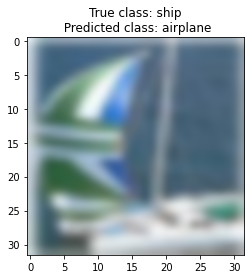

In [90]:
true_class = 8
predicted_class = 0
show_confused_image(X_test, y_test, y_test_preds, label_names, true_class, predicted_class)

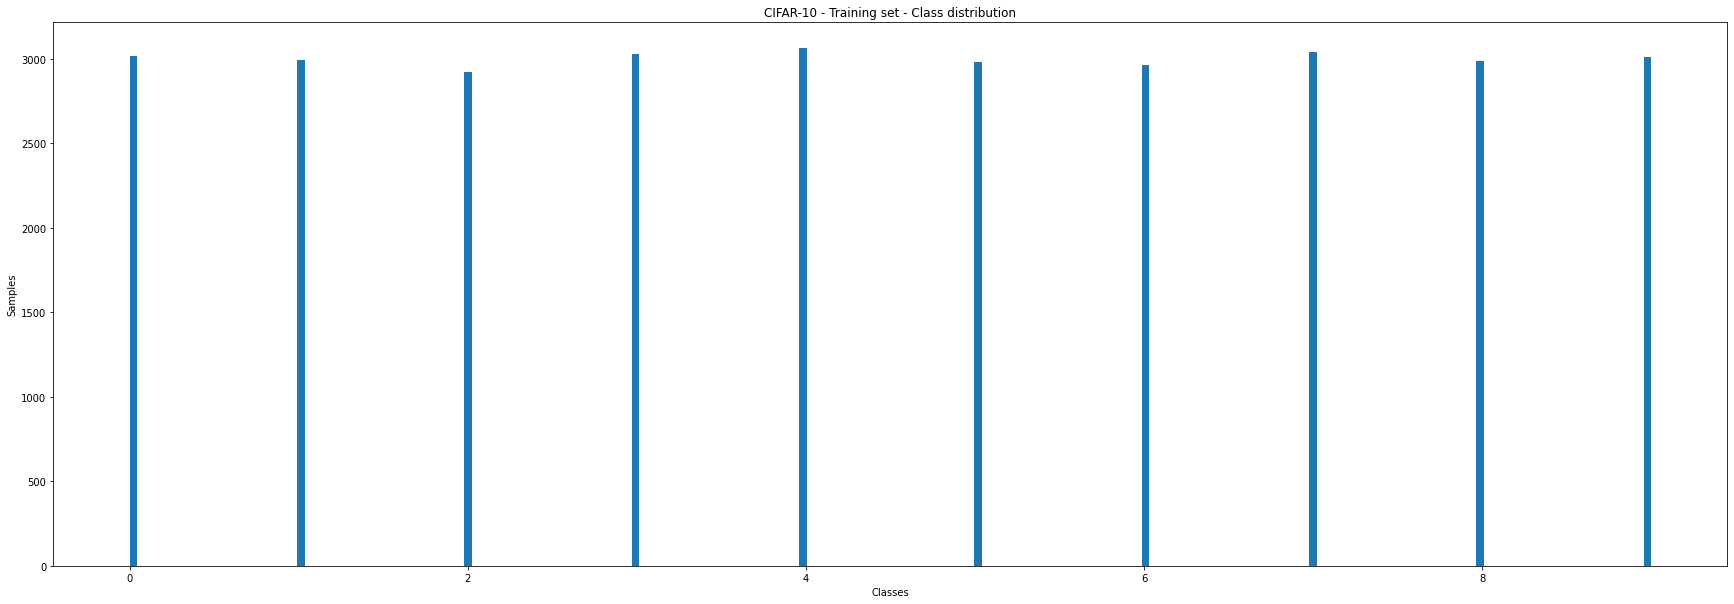

In [49]:
plt.figure(figsize=(30, 10))
plt.hist(y_train, bins=200)
plt.xlabel("Classes")
plt.ylabel("Samples")
plt.title("CIFAR-10 - Training set - Class distribution")
plt.show()

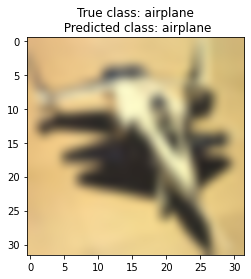

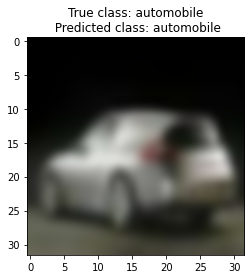

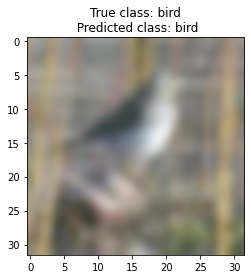

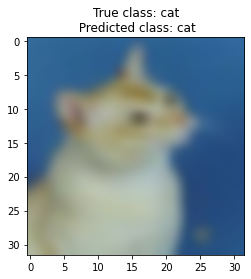

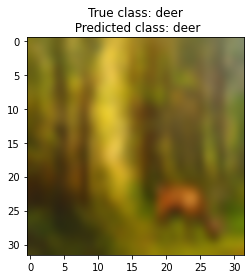

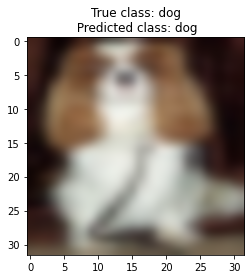

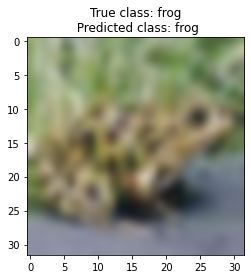

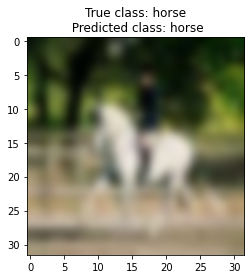

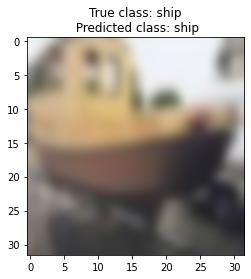

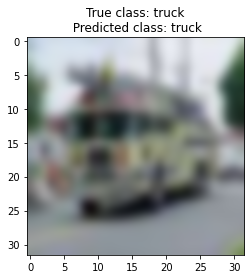

In [94]:
for n_class in range(len(label_names)):
  true_class, predicted_class = n_class, n_class
  show_image(X_test, y_test, y_test_preds, label_names, true_class, predicted_class)

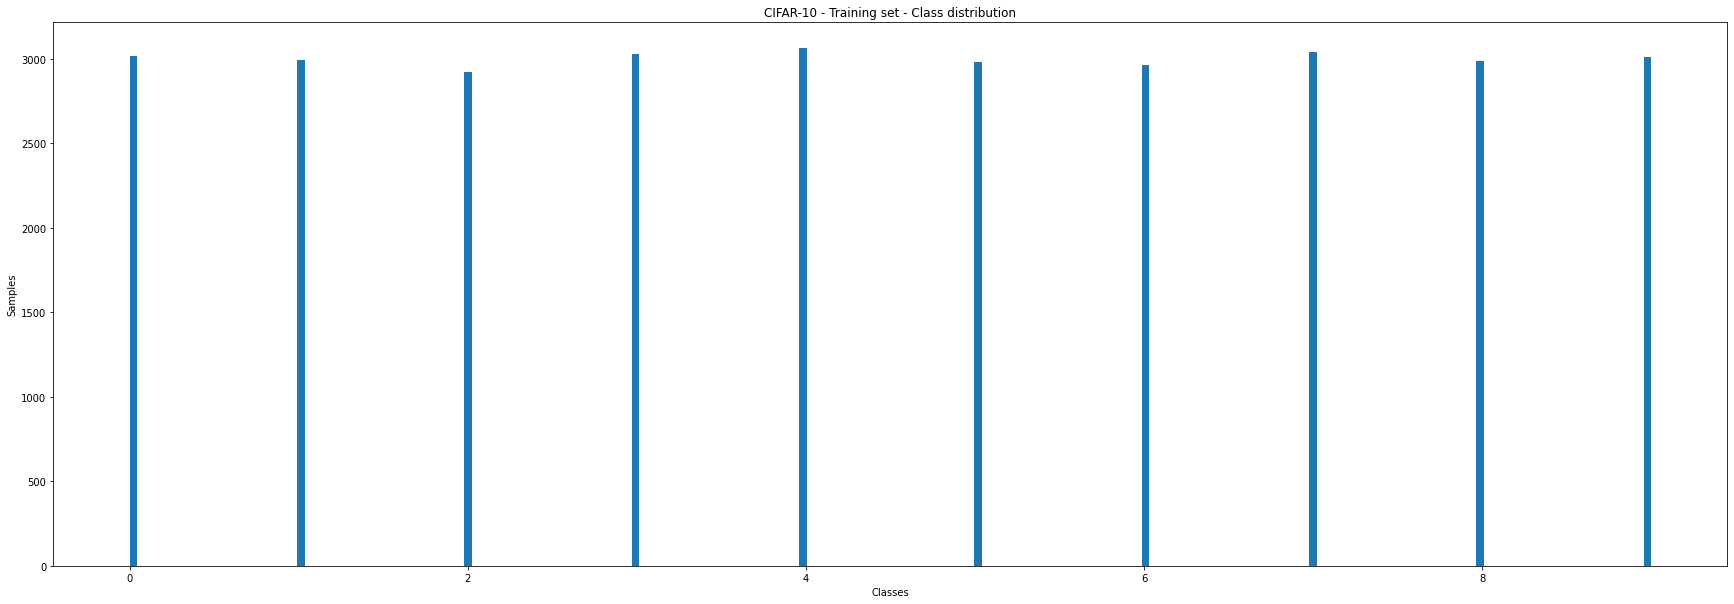

In [95]:
plt.figure(figsize=(30, 10))
plt.hist(y_train, bins=200)
plt.xlabel("Classes")
plt.ylabel("Samples")
plt.title("CIFAR-10 - Training set - Class distribution")
plt.show()

In [96]:
y_train_labels = [label_names[y_train[i]] for i in range(len(y_train))]

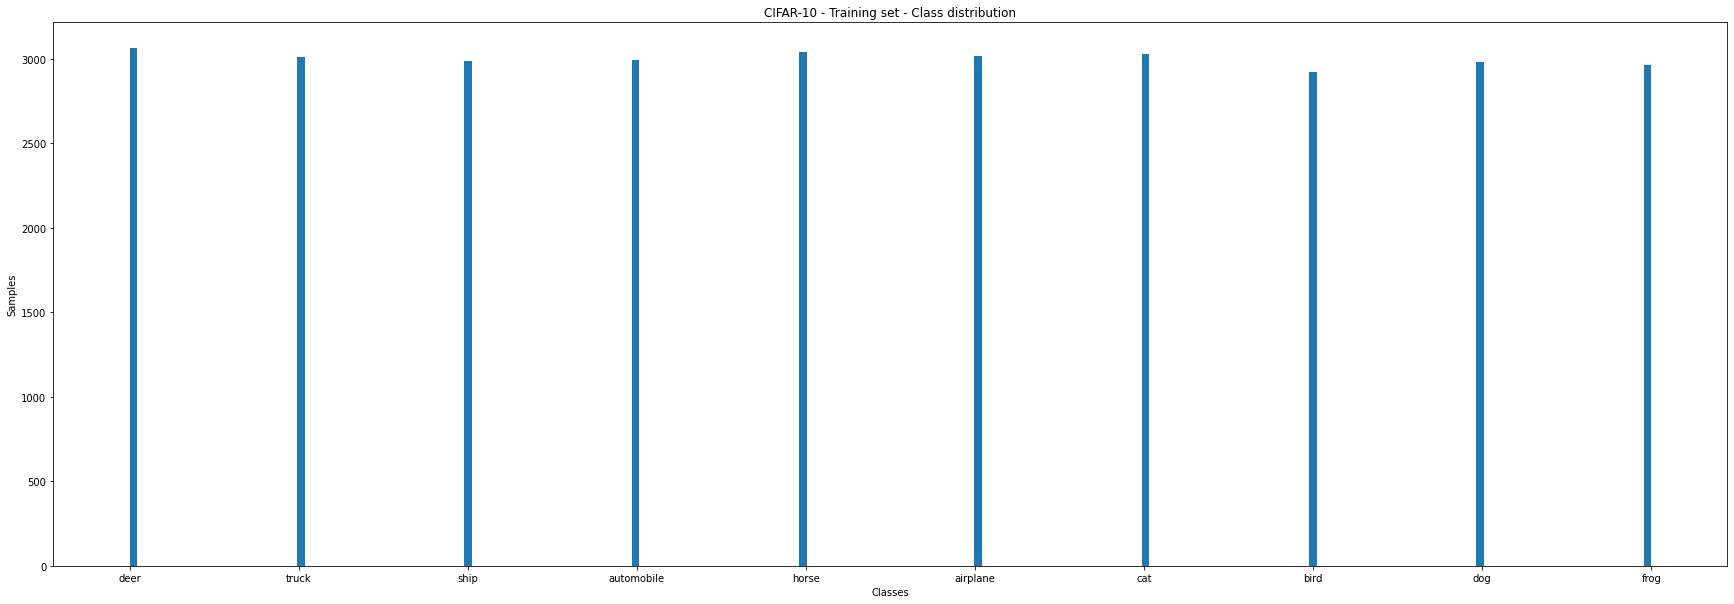

In [98]:
plt.figure(figsize=(30, 10))
plt.hist(y_train_labels, bins=200)
plt.xlabel("Classes")
plt.ylabel("Samples")
plt.title("CIFAR-10 - Training set - Class distribution")
plt.show()